# Foundation Models for Forecasting

* foundation models - concepts and introduction
* managing weights, data, model code, APIs
* using forecasting foundation models
* unified `sktime` interface
* best practice recommendations

In [1]:
import warnings

warnings.filterwarnings("ignore")

## What is a foundation model?

foundation model (FM) = **pre-trained models** that perform well on a wider range of data

"forecasting FM" = for the task of uni/multivariate forecasting

typically (but not necessarily) uses "transformer" or other advanced deep learning architecture

**how FM are typically used:**

1. provider trains model on large amount of data (secret/closed)
2. weights and code put online on marketplace (e.g., huggingface, replicate)
3. user forecasts using weights on their data

<img src="./imgs/global-fcst.png" alt="Global Forecast" style="width: 100%; max-width: 600px;">

**pre-trained model above typically from weight repository**

* "semi-open model" - weights can be downloaded and used with open code
* "gated model" - weights not accessible, only gated API (paid service subscription)

pre-trained on batches that are:
* typically large
* across various domains
* *not accessible to the end user*

**learning tasks**

* "originally": language prompting and generative language tasks
* forecasting: typically, univariate or multivariate forecasting
* other time series tasks may be supported but are rare

**relation to global forecasting**:

FM vanilla use are a form of "global forecasting" where:

* "global training" is done by the provider
* trained model provided as weights (download or gated)
* usage: "global prediction/inference" based on these weights

same principle! difference = "trained model handling"

* classical global forecasting = user trains on their own data, often small/mid size
* "foundation models" = model provider trains on large secret batch, shares only weights

<img src="./imgs/global-fcst.png" alt="Global Forecast" style="width: 100%; max-width: 600px;">

**zero-shot, few-shot, and fine-tuning**

* **zero-shot** = model does no training on user data, just "ingests" as "context"
* **few-shot** = model can be trained on user data samples to improve. Core model weights do not change.
* **fine-tuning** = adapting core model weights to user data, e.g., via LoRA, PEFT

**schematic overview weight flow diagram for semi-open model**

<img src="./imgs/FM conceptual.jpg" style="width: 100%; max-width: 600px;">

**gated model: weights are not downloadable but gated behind paywall**

**"degrees of openness"**

| Component                        | Commonly (2024–2025 Trend)    | Caveats |
|----------------------------------|--------------------------------------------|----------|
| Model Weights                    | ✅❌ Varies! Gated vs open | Lots of propaganda by providers |
| Inference Code                   | ✅❌ Varies! Gated vs open | usually open iff weights are |
| Model Architecture               | ✅ Mostly Open | visible for non-gated models |
| Training Code                    | ❌ Mostly Closed | "reveals" may be strategic, e.g., DeepSeek |
| Training Data                    | ❌ Mostly Closed | might involve public benchmarks |
| Data Collection Methodology      | ❌ Omitted or Vague | likely massive IP violations |
| Evaluation Benchmarks Used       | ✅ Often Open | propaganda - every model is "1st" |
| Fine-tuning Recipes              | ✅❌ Varies! Gated vs open | "gated fine-tuning" as model |
| Licenses  Information            | ✅❌ Varies. | stealth changes possible! |

capabilities and properties:

* "degrees of openness" (see above)
* learning task - univariate, multivariate forecasting; other time series tasks
* capability zero-shot, few-shot, fine-tune

### Time series foundation models in practice

Users should be aware of three dimensions:

* **methodological abstractions** - e.g., which task, how to test/benchmark
* **software & artefact handling** - e.g., library, weights, APIs
* **commercial & legal** - e.g., "lock-in", contracts, licenses

**High-level caveats - methodological**

lots of commercial propaganda...

* every model is 1st on some leaderboard
* pre-training batch is secret, could have contained public benchmark data
* massive influencer campaigns on social media and via academia (!)
* marketing claims may or may not hold up to scrutiny

Models may or may not work on your data!

**IMPORTANT: need to benchmark models on your own data**

will revisit below.

**High-level caveats - commercial & legal**

* gated models as core business model of companies! e.g., Nixtla, Prior labs
* models of equivalent performance may be available semi-open or fully open

Do the pros/cons - consider trade-offs, e.g.

* costs (running/initial)
* legal liabilities, licenses
* data protection, control of IP relevant content!

will revisit below.

**High-level caveats - software/artefacts**

2025 state: model code not easily installable! (outside `sktime`)

* most models have no proper package releases
* heavy or conflicted dependency sets
* highly inconsistent API
* often intentional push to user "lock-in" or "lock-down", esp gated

will revisit below.

### Handling FM under consistent API with `sktime`

`sktime` is the only framework where you can get these in a single place!

| Foundation Model | Provider | `sktime` estimator | open? | vendored? |
|------------------|----------|--------------------|------------|-------|
| Chronos(-Bolt)  | Amazon | `ChronosForecaster` | semi | Yes |
| LagLlama | Zalando | `LagLlamaForecaster` (PR stalled) | semi | Yes |
| MOIRAI | Salesforce | `MOIRAIForecaster` | semi | Yes |
| momentfm | US academia | `MomentFMForecaster` (next release) | semi | Yes |
| PatchTST | IBM | `PatchTSTForecaster` (PR stalled) | semi | Yes |
| Time-LLM | China | `TimeLLMForecaster` | semi | Yes |
| Time-MoE | China | `TimeMoEForecaster` | semi | Yes |
| TimesFM | Google | `TimesFMForecaster` | semi | Yes |
| TinyTimeMixer | IBM | `TinyTimeMixerForecaster` | semi | Yes |

Foundation model wishlist and tracking issue:

https://github.com/sktime/sktime/issues/6177

(gated models are in-scope, but not prioritized)


without `sktime`, highly inconsistent APIs, compare:

**Moirai**
```
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=prediction_length,
    context_length=context_length,
    patch_size=patch_size,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=batch_size)
forecasts = predictor.predict(test_data.input)
```

**TinyTimeMixer**
```
model, _ = TinyTimeMixerForPrediction.from_pretrained(
    model_path,
    revision=revision,
    config=config,
    output_loading_info=True,
    ignore_mismatched_sizes=True,
)

outputs = model(
    past_values=past_values,
    observed_mask=observed_mask,
)
```

`sktime`-less users need to manage:
* **model code**, e.g., source installation
* **model code dependencies**, python packages
* **weights**, e.g., .pkl, .pt, .bin, .h5 files
* **weight dependencies**, python packages

`sktime` is **the only package** that provides access to many FM under single interface.

**users first** and **neutrality** mission.

(donations accepted via gcos.ai and tax deductible)

`sktime` API abstracts this away and manages on framework level

<img src="./imgs/fm-simple.png" alt="Foundation Model Overview" style="width: 100%; max-width: 600px;">

In [1]:
from sktime.datasets import load_airline

# Load the dataset for example
y = load_airline()

# DL models need to set a prediction length (same as simpler DL models)
pred_len = 16

#### Example: TinyTimeMixer

- **Research Paper:** [Tiny Time Mixers (TTMs): Fast Pre-trained Models for Enhanced Zero/Few-Shot Forecasting of Multivariate Time Series](https://www.researchgate.net/profile/Vijay-Ekambaram/publication/381111250_Tiny_Time_Mixers_TTMs_Fast_Pre-trained_Models_for_Enhanced_ZeroFew-Shot_Forecasting_of_Multivariate_Time_Series/links/665d8c5d0b0d2845747de5f5/Tiny-Time-Mixers-TTMs-Fast-Pre-trained-Models-for-Enhanced-Zero-Few-Shot-Forecasting-of-Multivariate-Time-Series.pdf)
- **Official Code:** [ibm-granite/granite-tsfm](https://github.com/ibm-granite/granite-tsfm)

In [2]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster

**Zero-Shot Forecasting**

with the default configuration, model performs zero-shot

In [3]:
forecaster = TinyTimeMixerForecaster()

forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

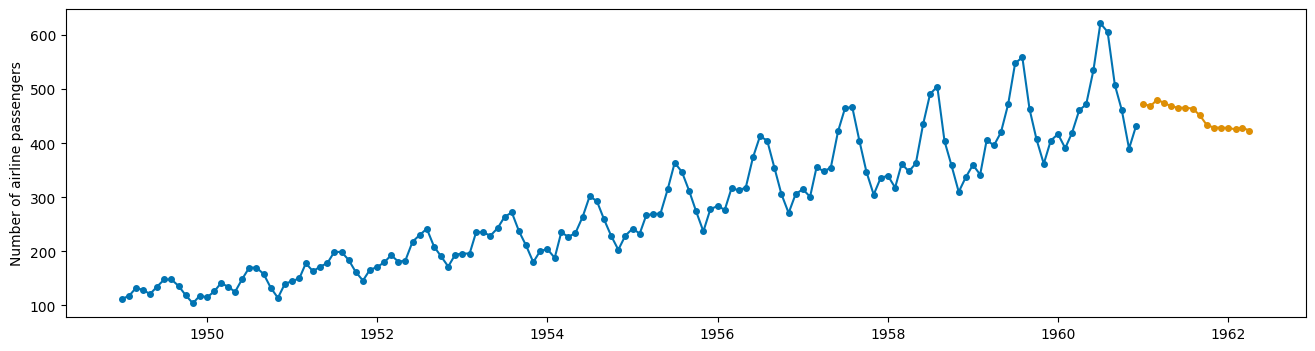

In [4]:
from sktime.utils.plotting import plot_series

plot_series(y, y_pred)

where are weights here?

given in `model_path`, can be:

* `huggingface` model string - uses HF backend then (default)
* local path in folder
* `None` - full tuning from pristine if `fit_strategy="full"`

**Fine-Tuning**

works via providing fine-tuning config.

Same interface - fine-tunes on input data!

In [5]:
forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": 32,
        "prediction_length": pred_len,
    },
    training_args={
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

C:\Workspace\sktime\sktime\forecasting\ttm.py:374: UserWarning: Invalid configuration detected. The provided values do not satisfy the required condition:
context_length / num_patches == patch_length == patch_stride
Provided configuration:
- context_length: 32
- num_patches: 8
- patch_length: 64
- patch_stride: 64
Configuration has been automatically updated to:
- context_length: 32
- num_patches: 8
- patch_length: 4
- patch_stride: 4
  warn(msg)
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm/TTM and are newly initialized because the shapes did not match:
- backbone.encoder.patcher.weight: found shape torch.Size([192, 64]) in the checkpoint and torch.Size([192, 4]) in the model instantiated
- head.base_forecast_block.bias: found shape torch.Size([96]) in the checkpoint and torch.Size([16]) in the model instantiated
- head.base_forecast_block.weight: found shape torch.Size([96, 1024]) in the checkpoint and torch.Size([16, 1024]) in the m

  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 17.5363, 'train_samples_per_second': 387.768, 'train_steps_per_second': 17.107, 'train_loss': 279.64619791666667, 'epoch': 100.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

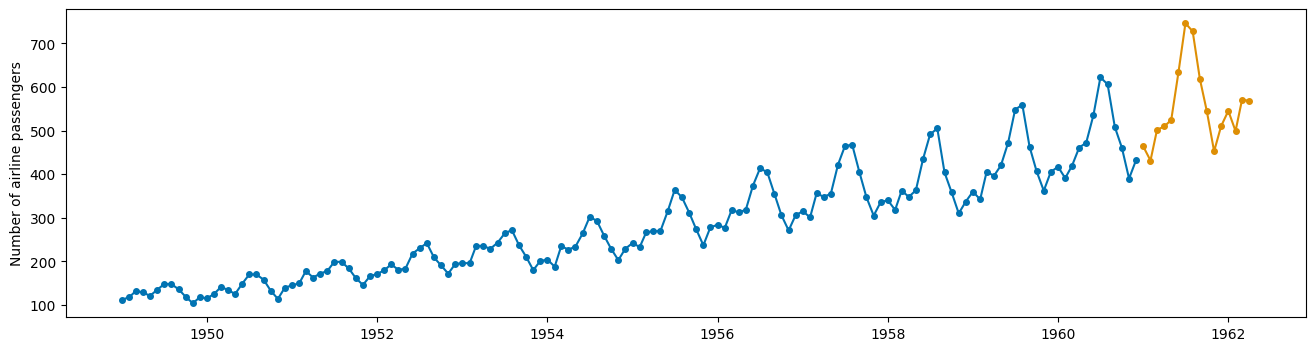

In [6]:
plot_series(y, y_pred)

#### TimesFM

- **Research Paper:** [A Decoder-Only Foundation Model for Time-Series Forecasting](https://arxiv.org/abs/2310.10688)
- **Official Code:** [google-research/timesfm](https://github.com/google-research/timesfm)

**Zero-Shot Forecasting**

In [34]:
from sktime.forecasting.timesfm_forecaster import TimesFMForecaster

forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=pred_len,
)

In [36]:
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

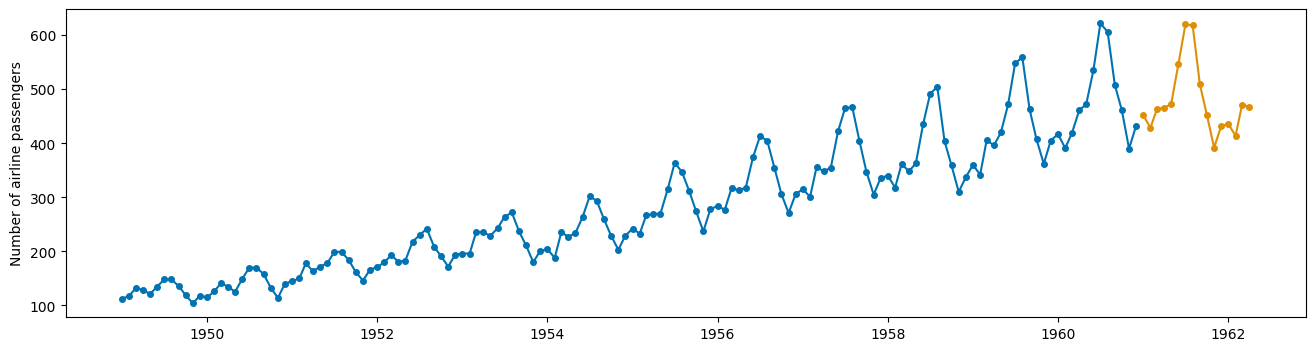

In [37]:
plot_series(y, y_pred)

### managing model code - `sktime` forks, source install, pypi

typical dependency set of an open FM package

```
[project]
...
dependencies = [
  "torch>=2.1",
  "lightning>=2.0",
  "gluonts~=0.14.3",
  "numpy~=1.26.0",
  "scipy~=1.11.3",
  "einops==0.7.*",
  "jaxtyping~=0.2.24",
  "python-dotenv==1.0.0",
  "hydra-core==1.3",
  ...,
]
```

**`sktime` forks typically more stable, trustworthy, and reliable than official sources!**

* optimized dependency management
    * often very strict dep requirements - can be impossible to satisfy!
    * stability via `sktime` deprecation management
* often, no (trustworthy) pypi release available
    * source install is unstable, not suitable for deployment
    * model code may not be on pypi as package
    * non-affiliated people upload inofficial releases - **possible supply chain attacks!**
    * `sktime` is "trusted" package managed by known people & orgs
* license stability
    * stealth license changes even by commercial actors!
    * licenses remain explicit and stable, deprecation management

Default: forked code in [`sktime/libs`](TODO), license attached with the official code is kept as is and clearly visible.

Source installation can be selected via `use_source_package` parameter

Example, to use `TinyTimeMixer` from source package:

1. install from source

In [7]:
# e.g., to install the 0.2.3 version of timesfm
# !pip install git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.3 --quiet

2. set the `use_source_package` flag to `True`

In [39]:
forecaster = TinyTimeMixerForecaster(
    use_source_package=True,
)

### Hierarchical and probabilistic forecasting

`sktime` automatically manages bhierarchical and probabilistic forecasts for FM!

* works via the familiar interface - broadcasting and composition
* only a single instance of the FM is spawned in memory in hierarchical or probabilistic ensembles

example: let's look at Amazon Chronos bolt.

Performance and memory for single time series:

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

c:\ProgramData\anaconda3\envs\sktime-skpro-skbase-312\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Franz Kiraly\.cache\huggingface\hub\models--amazon--chronos-bolt-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

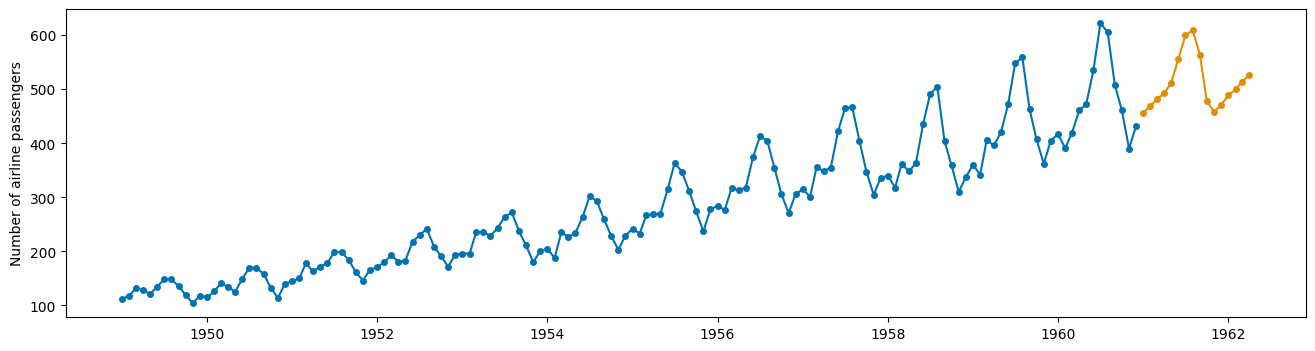

In [9]:
from sktime.forecasting.chronos import ChronosForecaster

chronos_bolt = ChronosForecaster("amazon/chronos-bolt-tiny")

chronos_bolt.fit(y, fh=list(range(1, pred_len+1)))
y_pred = chronos_bolt.predict()

plot_series(y, y_pred)

#### with hierarchical data

In [24]:
from sktime.datasets import load_hierarchical_sales_toydata

y_hier = load_hierarchical_sales_toydata()
y_hier

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

In [ ]:
chronos_bolt.fit(y_hier, fh=list(range(1, pred_len+1)))

ChronosForecaster(model_path='amazon/chronos-bolt-tiny')

In [14]:
y_pred_hier = chronos_bolt.predict()
y_pred_hier

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  127.047623
                                2005-02  166.439606
                                2005-03  134.411652
                                2005-04  142.272049
                                2005-05  122.165100
...                                             ...
Food preservation Fridges       2005-12  138.554977
                                2006-01  129.582779
                                2006-02  167.958160
                                2006-03  143.666641
                                2006-04  137.430206

[64 rows x 1 columns]

same amount of memory! Check usage in OS profiler while executing.

#### getting probabilistic predictions

... works via composition

In [26]:
from sktime.forecasting.conformal import ConformalIntervals

chronos_with_proba = ConformalIntervals(chronos_bolt, sample_frac=.1)
chronos_with_proba.fit(y_hier, fh=list(range(1, pred_len+1)))
y_pred_hier_proba = chronos_with_proba.predict_interval(coverage=0.9)
y_pred_hier_proba

Sales            
                                                0.9            
                                              lower       upper
Product line      Product group Date                           
Food preparation  Hobs          2005-01   35.001233  199.658633
                                2005-02    38.38515  144.803229
                                2005-03    89.27318   140.89095
                                2005-04   86.742236  212.625272
                                2005-05   73.447153  196.591864
...                                             ...         ...
Food preservation Fridges       2005-12  137.530986   200.51733
                                2006-01   129.58854   235.43547
                                2006-02  104.873163  184.173531
                                2006-03   92.329015  177.199643
                                2006-04  102.491201  143.014321

[64 rows x 2 columns]

example: STL bootstrap prediction intervals

In [29]:
from sktime.forecasting.moirai_forecaster import MOIRAIForecaster
from sktime.forecasting.compose import BaggingForecaster
from sktime.transformations.bootstrap import STLBootstrapTransformer

chronos_bootstrap = BaggingForecaster(STLBootstrapTransformer(), chronos_bolt)

y = load_airline()
chronos_bootstrap.fit(y, fh=range(1, 12))

y_pred_bootstrap = chronos_bootstrap.predict_interval()
y_pred_bootstrap


Number of airline passengers            
                                    0.9            
                                  lower       upper
time_index                                         
1961-01                      456.820251  609.058472
1961-02                      458.466278  612.661987
1961-03                      445.122803  604.958374
1961-04                      451.234772  601.825317
1961-05                      460.205933  613.859375
1961-06                      439.005798  595.531067
1961-07                      446.579529  604.985107
1961-08                      444.600677  599.598022
1961-09                      453.176758  603.560059
1961-10                      453.562195  604.656006
1961-11                      473.909668  617.659607

### FM on the legal side

FM are "multi-component" technology - API, weights, model code, data, ...

* different artefacts under different licenses
* **artefacts** and **usage** may be under different licenses
* **licenses can be unstable!** stealth changes possible on HF or source installs
* gated APIs usually subject to additional Terms and Conditions (which can change)

legislators and regulators tend to be confused about these...

<img src="./imgs/fm-license.png" style="width: 100%; max-width: 600px;">

"data" is another component:

* "feeding" data to a gated API feeds the data to the provider!
    * data and data format may transport IP protected content!
* data "stolen" by the provider may impact fine-tuned models or end-to-end pipes

mid-2025 - unclear status with regards to EU AI act

`sktime` tries to minimize license issues but cannot entirely remove them!

* "frozen" code with version management
* forks branch off at permissive licenses (prior stealth change to restrictive)
    * view licenses in `libs` folder

Caveat: if using weights, inspect weights licenses and T&C

### methodology - so should I use foundation models now?

FM are promosing category of models, but:

* many competing FM!
* every FM is 1st in some benchmark...
* may or may not be useful for your data!

General advice same as for other model:

**test and benchmark on your own data!**

**and compare pros/cons w.r.t. requirements for your use case!**

(e.g., simplicity/interpretability, compute/memory, local/cloud, security)

In [31]:
from sktime.benchmarking.forecasting import ForecastingBenchmark

benchmark = ForecastingBenchmark()


In [32]:
from sktime.forecasting.chronos import ChronosForecaster
from sktime.forecasting.naive import NaiveForecaster

benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="mean", sp=12),
    estimator_id="NaiveForecaster-mean-v1",
)
benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="last", sp=12),
    estimator_id="NaiveForecaster-last-v1",
)
benchmark.add_estimator(
    estimator=ChronosForecaster("amazon/chronos-bolt-tiny"),
    estimator_id="chronos-bolt-tiny",
)

In [33]:
from sktime.datasets import load_airline
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError
from sktime.split import ExpandingWindowSplitter

dataset_loader = load_airline
cv_splitter = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=12,
)
scorers = [MeanSquaredPercentageError()]

benchmark.add_task(
    dataset_loader,
    cv_splitter,
    scorers,
)

In [72]:
df = benchmark.run("./forecasting_results.csv")
df = df.set_index("model_id").T

SELECTED_ROWS = [
    "MeanSquaredPercentageError_mean",
    "fit_time_mean",
    "pred_time_mean",
]

df.loc[SELECTED_ROWS]

model_id,NaiveForecaster-last-v1,NaiveForecaster-mean-v1,chronos-bolt-tiny
MeanSquaredPercentageError_mean,0.014104,0.118918,0.019452
fit_time_mean,0.003798,0.003932,0.250292
pred_time_mean,0.035543,0.011438,0.093804


complex models are often good, but not always the best!

**trust but verify** :-)

## Recap - Foundation Models

* **pre-trained DL models** with zero-shot, few-shot and/or fine-tune capabilities
* varying degrees of openness - fully open, semi-open, gated
* hard to use directly, install, deploy, test - lock-in & lock-out dynamics

`sktime` unified API makes use and comparison of multiple FM easy!

* handling code, weights, parameters under the hood; zero-shot and fine-tuning
* different weights backends - local, weight hubs, train from scratch
* FM vendor mini-packages with stable code, interfaces, licenses

**`sktime` is currently only framework that does this! Only neutral framework!**

contribute if you find this useful.

**best practice: always try and test on your own data!** FM or not.

## What's Next?

Developing sktime compatible components

* how you can add components yourself
* `sktime` model marketplace
* example - creating a custom forecaster